In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os, glob, joblib
from torch.utils.data import DataLoader
#from torch.autograd import grad
import cf_matrix
from sklearn.metrics import accuracy_score,confusion_matrix

In [2]:
##### LOAD #########
# choose load file name 
train_path="/home/bhagya/Cross_corpora_data_Bhagya/"
test_path="/home/bhagya/Cross_corpora_data_Bhagya/"

f1 = train_path+'X_Original_KGP_train_cms.npy'
f2 = train_path+'y_Original_KGP_train_cms.npy'
#f3 = train_path+'X_train_KGP_kaldi_aug_mfcc_cms.npy'
#f4 = train_path+'y_train_KGP_kaldi_aug_mfcc_cms.npy'
f5 = test_path+'X_Original_KGP_test_cms.npy'
f6 = test_path+'y_Original_KGP_test_cms.npy'

X_train = np.load(f1,allow_pickle=True)
#X_aug=np.load(f3,allow_pickle=True)
X_valid = np.load(f5,allow_pickle=True)
y_train = np.load(f2,allow_pickle=True)
#y_aug=np.load(f4,allow_pickle=True)
y_valid = np.load(f6,allow_pickle=True)

# Check that we've recovered the right data
print(f'X_train:{X_train.shape}, y_train:{y_train.shape}')
#print(f'X_aug:{X_aug.shape}, y_aug:{y_aug.shape}') 
print(f'X_valid:{X_valid.shape}, y_valid:{y_valid.shape}')

X_train:(3797, 300, 20), y_train:(3797,)
X_valid:(247, 300, 20), y_valid:(247,)


In [3]:
print(np.unique(y_train,return_counts=True))
#print(np.unique(y_aug,return_counts=True))
print(np.unique(y_valid,return_counts=True))

(array([0, 1, 2, 3, 4], dtype=object), array([647, 896, 685, 937, 632]))
(array([0, 1, 2, 3, 4], dtype=object), array([50, 45, 46, 51, 55]))


In [4]:
# #not doing where separate source domains are needed as X_aug such as wgdrl
# X_train=np.concatenate((X_train,X_aug))
# del X_aug
# y_train=np.concatenate((y_train,y_aug))
# del y_aug

In [5]:
print(X_train.shape)
print(np.unique(y_train,return_counts=True))

(3797, 300, 20)
(array([0, 1, 2, 3, 4], dtype=object), array([647, 896, 685, 937, 632]))


In [6]:
#ecapa noramal
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import math
import sys
sys.path.insert(0, "/home/bhagya/asv-subtools-master/pytorch/")
import libs.support.utils as utils
from libs.nnet import *

# refs:
# 1.  ECAPA-TDNN: Emphasized Channel Attention, Propagation and Aggregation in TDNN Based Speaker Verification
#           https://arxiv.org/abs/2005.07143
# 2.  Unofficial implementation of the ECAPA-TDNN model.
#       https://github.com/lawlict/ECAPA-TDNN




''' Res2Conv1d + BatchNorm1d + ReLU
'''
class Res2Conv1dReluBn(nn.Module):
    '''
    inputs_dim == out_channels == channels
    '''
    def __init__(self, channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False, scale=4):
        super().__init__()
        assert channels % scale == 0, "{} % {} != 0".format(channels, scale)
        self.scale = scale
        self.width = channels // scale
        self.nums = scale if scale == 1 else scale - 1

        self.convs = []
        self.bns = []
        for i in range(self.nums):
            self.convs.append(nn.Conv1d(self.width, self.width, kernel_size, stride, padding, dilation, bias=bias))
            self.bns.append(nn.BatchNorm1d(self.width))
        self.convs = nn.ModuleList(self.convs)
        self.bns = nn.ModuleList(self.bns)

    def forward(self, x):
        out = []
        spx = torch.split(x, self.width, 1)
        for i in range(self.nums):
            if i == 0:
                sp = spx[i]
            else:
                sp = sp + spx[i]
            # Order: conv -> relu -> bn
            sp = self.convs[i](sp)
            sp = self.bns[i](F.relu(sp))
            out.append(sp)
        if self.scale != 1:
            out.append(spx[self.nums])
        out = torch.cat(out, dim=1)
        return out



''' Conv1d + BatchNorm1d + ReLU
'''
class Conv1dReluBn(nn.Module):
    def __init__(self, inputs_dim, out_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False):
        super().__init__()
        self.conv = nn.Conv1d(inputs_dim, out_channels, kernel_size, stride, padding, dilation, bias=bias)
        self.bn = nn.BatchNorm1d(out_channels)

    def forward(self, x):
        return self.bn(F.relu(self.conv(x)))



''' The SE connection of 1D case.
'''
class SE_Connect(nn.Module):
    def __init__(self, channels, s=4):
        super().__init__()
        assert channels % s == 0, "{} % {} != 0".format(channesl, s)
        self.linear1 = nn.Linear(channels, channels // s)
        self.linear2 = nn.Linear(channels // s, channels)

    def forward(self, x):
        out = x.mean(dim=2)
        out = F.relu(self.linear1(out))
        out = torch.sigmoid(self.linear2(out))
        out = x * out.unsqueeze(2)
        return out

#Another implementation of SE_Connect
# class SE_Connect(nn.Module):
#     def __init__(self, channels, bottleneck=128):
#         super(SE_Connect, self).__init__()
#         self.se = nn.Sequential(
#             nn.AdaptiveAvgPool1d(1),
#             nn.Conv1d(channels, bottleneck, kernel_size=1, padding=0),
#             nn.ReLU(),
#             # nn.BatchNorm1d(bottleneck),
#             nn.Conv1d(bottleneck, channels, kernel_size=1, padding=0),
#             nn.Sigmoid(),
#             )

#     def forward(self, input):
#         x = self.se(input)
#         return input * x


''' SE-Res2Block.
    Note: residual connection is implemented in the ECAPA_TDNN model, not here.
'''
def SE_Res2Block(channels, kernel_size, stride, padding, dilation, scale):
    return nn.Sequential(
        Conv1dReluBn(channels, channels, kernel_size=1, stride=1, padding=0),
        Res2Conv1dReluBn(channels, kernel_size, stride, padding, dilation, scale=scale),
        Conv1dReluBn(channels, channels, kernel_size=1, stride=1, padding=0),
        SE_Connect(channels)
    )



''' Attentive weighted mean and standard deviation pooling.
'''
class AttentiveStatsPool(nn.Module):
    def __init__(self, in_dim, bottleneck_dim):
        super().__init__()
        # Use Conv1d with stride == 1 rather than Linear, then we don't need to transpose inputs.
        self.linear1 = nn.Conv1d(in_dim, bottleneck_dim, kernel_size=1) # equals W and b in the paper
        self.linear2 = nn.Conv1d(bottleneck_dim, in_dim, kernel_size=1) # equals V and k in the paper

    def forward(self, x):
        # DON'T use ReLU here! In experiments, I find ReLU hard to converge.
        alpha = torch.tanh(self.linear1(x))
        alpha = torch.softmax(self.linear2(alpha), dim=2)
        mean = torch.sum(alpha * x, dim=2)
        residuals = torch.sum(alpha * x ** 2, dim=2) - mean ** 2
        std = torch.sqrt(residuals.clamp(min=1e-9))
        return torch.cat([mean, std], dim=1)



''' Implementation of
    "ECAPA-TDNN: Emphasized Channel Attention, Propagation and Aggregation in TDNN Based Speaker Verification".

    Note that we DON'T concatenate the last frame-wise layer with non-weighted mean and standard deviation,
    because it brings little improvment but significantly increases model parameters.
    As a result, this implementation basically equals the A.2 of Table 2 in the paper.
'''
class ECAPA_TDNN(TopVirtualNnet):
    def init(self, inputs_dim, num_targets, channels=512, embd_dim=192,
             aug_dropout=0.5, tail_dropout=0.5, training=True,
             extracted_embedding="near", mixup=False, mixup_alpha=1.0,
             pooling="ecpa-attentive", pooling_params={}, fc1=False, fc1_params={}, fc2_params={},
             margin_loss= True, margin_loss_params={}, use_step=False, step_params={}, transfer_from="softmax_loss" ):


        default_pooling_params = {
            "num_head":1,
            "hidden_size":64,
            "share":True,
            "affine_layers":1,
            "context":[0],
            "stddev":True,
            "temperature":False,
            "fixed":True
        }

        default_fc_params = {
            "nonlinearity":'relu', "nonlinearity_params":{"inplace":True},
            "bn-relu":False,
            "bn":True,
            "bn_params":{"momentum":0.5, "affine":True, "track_running_stats":True}
            }


        default_margin_loss_params = {
            "method":"am", "m":0.2,
            "feature_normalize":True, "s":30,
            "double":False,
            "mhe_loss":False, "mhe_w":0.01,
            "inter_loss":0.,
            "ring_loss":0.,
            "curricular":False}

        default_step_params = {
            "T":None,
            "m":False, "lambda_0":0, "lambda_b":1000, "alpha":5, "gamma":1e-4,
            "s":False, "s_tuple":(30, 12), "s_list":None,
            "t":False, "t_tuple":(0.5, 1.2),
            "p":False, "p_tuple":(0.5, 0.1)
        }

        self.use_step = use_step
        self.step_params = step_params
        self.extracted_embedding = extracted_embedding

        pooling_params = utils.assign_params_dict(default_pooling_params, pooling_params)
        fc1_params = utils.assign_params_dict(default_fc_params, fc1_params)
        fc2_params = utils.assign_params_dict(default_fc_params, fc2_params)
        margin_loss_params = utils.assign_params_dict(default_margin_loss_params, margin_loss_params)
        step_params = utils.assign_params_dict(default_step_params, step_params)


        #self.mixup = Mixup(alpha=mixup_alpha) if mixup else None
        #self.pcmvn = AdaptivePCMN(20)
        self.layer1 = Conv1dReluBn(inputs_dim, channels, kernel_size=5, padding=2)
        self.layer2 = SE_Res2Block(channels, kernel_size=3, stride=1, padding=2, dilation=2, scale=8)
        self.layer3 = SE_Res2Block(channels, kernel_size=3, stride=1, padding=3, dilation=3, scale=8)
        self.layer4 = SE_Res2Block(channels, kernel_size=3, stride=1, padding=4, dilation=4, scale=8)
        cat_channels = channels * 3
        self.conv = nn.Conv1d(cat_channels, cat_channels, kernel_size=1)
        self.bn_conv = nn.BatchNorm1d(cat_channels)

        # Pooling
        stddev = pooling_params.pop("stddev")
        if pooling == "attentive":
            self.stats = AttentiveStatisticsPooling(cat_channels, hidden_size=pooling_params["hidden_size"],context=pooling_params["context"], stddev=stddev)
            self.bn_stats = nn.BatchNorm1d(cat_channels * 2)
            self.fc1 = ReluBatchNormTdnnLayer(cat_channels * 2, embd_dim, **fc1_params) if fc1 else None
        elif pooling == "ecpa-attentive":
            self.stats = AttentiveStatsPool(cat_channels,128)
            self.bn_stats = nn.BatchNorm1d(cat_channels * 2)
            self.fc1 = ReluBatchNormTdnnLayer(cat_channels * 2, embd_dim, **fc1_params) if fc1 else None
        elif pooling == "multi-head":
            self.stats = MultiHeadAttentionPooling(cat_channels, stddev=stddev, **pooling_params)
            self.bn_stats = nn.BatchNorm1d(cat_channels * 2)
            self.fc1 = ReluBatchNormTdnnLayer(cat_channels * 2, embd_dim, **fc1_params) if fc1 else None
        elif pooling == "global-multi":
            self.stats = GlobalMultiHeadAttentionPooling(cat_channels,stddev=stddev, **pooling_params)
            self.bn_stats = nn.BatchNorm1d(cat_channels * 2* pooling_params["num_head"])
            self.fc1 = ReluBatchNormTdnnLayer(cat_channels * 2* pooling_params["num_head"], embd_dim, **fc1_params) if fc1 else None
        elif pooling == "multi-resolution":
            self.stats = MultiResolutionMultiHeadAttentionPooling(cat_channels, **pooling_params)
            self.bn_stats = nn.BatchNorm1d(cat_channels * 2* pooling_params["num_head"])
            self.fc1 = ReluBatchNormTdnnLayer(cat_channels * 2* pooling_params["num_head"], embd_dim, **fc1_params) if fc1 else None

        else:
            self.stats = StatisticsPooling(cat_channels, stddev=stddev)
            self.bn_stats = nn.BatchNorm1d(cat_channels * 2)
            self.fc1 = ReluBatchNormTdnnLayer(cat_channels * 2, embd_dim, **fc1_params) if fc1 else None

        self.tail_dropout = torch.nn.Dropout2d(p=tail_dropout) if tail_dropout > 0 else None

        if fc1:
            fc2_in_dim = embd_dim
        else:
            fc2_in_dim = cat_channels * 2
        self.fc2 = ReluBatchNormTdnnLayer(fc2_in_dim, embd_dim, **fc2_params)
        self.tail_dropout = torch.nn.Dropout2d(p=tail_dropout) if tail_dropout > 0 else None

         # Loss
        # Do not need when extracting embedding.
        if training :
            if margin_loss:
                self.loss = MarginSoftmaxLoss(embd_dim, num_targets, **margin_loss_params)
            else:
                self.loss = SoftmaxLoss(embd_dim, num_targets)
                # self.loss = AngleLoss(embd_dim,num_targets)
            self.wrapper_loss = MixupLoss(self.loss, self.mixup) if mixup else None
            # An example to using transform-learning without initializing loss.affine parameters
            self.transform_keys = ["layer2","layer3","layer4","conv","stats","fc1","fc2"]

            if margin_loss and transfer_from == "softmax_loss":
                # For softmax_loss to am_softmax_loss
                self.rename_transform_keys = {"loss.affine.weight":"loss.weight"}

    @utils.for_device_free
    def forward(self, x):
        #x = self.mixup(x)
        #x = self.pcmvn(x)
        out1 = self.layer1(x)
        out2 = self.layer2(out1) + out1
        out3 = self.layer3(out1 + out2) + out1 + out2
        out4 = self.layer4(out1 + out2 + out3) + out1 + out2 + out3
        out = torch.cat([out2, out3, out4], dim=1)
        out = self.bn_conv(F.relu(self.conv(out)))
        x = self.bn_stats(self.stats(out))
        if len(x.shape) !=3:
            x = x.unsqueeze(dim=2)
        x = self.auto(self.fc1, x)
        x = self.fc2(x)
        x = self.auto(self.tail_dropout, x)
        return x

    @utils.for_device_free
    def get_loss(self, inputs, targets):
        """Should call get_loss() after forward() with using Xvector model function.
        e.g.:
            m=Xvector(20,10)
            loss=m.get_loss(m(inputs),targets)

        model.get_loss [custom] -> loss.forward [custom]
          |
          v
        model.get_accuracy [custom] -> loss.get_accuracy [custom] -> loss.compute_accuracy [static] -> loss.predict [static]
        """
        if self.wrapper_loss is not None:
            return self.wrapper_loss(inputs, targets)
        else:
            return self.loss(inputs, targets)

    @utils.for_device_free
    def get_accuracy(self, targets):
        """Should call get_accuracy() after get_loss().
        @return: return accuracy
        """
        if self.wrapper_loss is not None:
            return self.wrapper_loss.get_accuracy(targets)
        else:
            return self.loss.get_accuracy(targets)

    @for_extract_embedding(maxChunk=10000, isMatrix=True)
    def extract_embedding(self, inputs):
        out1 = self.layer1(inputs)
        out2 = self.layer2(out1) + out1
        out3 = self.layer3(out1 + out2) + out1 + out2
        out4 = self.layer4(out1 + out2 + out3) + out1 + out2 + out3
        out = torch.cat([out2, out3, out4], dim=1)
        out = self.bn_conv(F.relu(self.conv(out)))
        x = self.bn_stats(self.stats(out))
        if len(x.shape) !=3:
            x = x.unsqueeze(dim=2)
        if self.extracted_embedding == "far":
            assert self.fc1 is not None
            xvector = self.fc1.affine(x)
        elif self.extracted_embedding == "near_affine":
            x = self.auto(self.fc1, x)
            xvector = self.fc2.affine(x)
        elif self.extracted_embedding == "near":
            x = self.auto(self.fc1, x)
            xvector = self.fc2(x)
        else:
            raise TypeError("Expected far or near position, but got {}".format(self.extracted_embedding))
        return xvector
    def get_warmR_T(T_0, T_mult, epoch):
        n = int(math.log(max(0.05, (epoch / T_0 * (T_mult - 1) + 1)), T_mult))
        T_cur = epoch - T_0 * (T_mult ** n - 1) / (T_mult - 1)
        T_i = T_0 * T_mult ** (n)
        return T_cur, T_i

    def compute_decay_value(self, start, end, T_cur, T_i):
        # Linear decay in every cycle time.
        return start - (start - end)/(T_i-1) * (T_cur%T_i)

    def step(self, epoch, this_iter, epoch_batchs):
        # Heated up for t and s.
        # Decay for margin and dropout p.
        if self.use_step:
            if self.step_params["m"]:
                current_postion = epoch*epoch_batchs + this_iter
                lambda_factor = max(self.step_params["lambda_0"],
                                 self.step_params["lambda_b"]*(1+self.step_params["gamma"]*current_postion)**(-self.step_params["alpha"]))
                self.loss.step(lambda_factor)

            if self.step_params["T"] is not None and (self.step_params["t"] or self.step_params["p"]):
                T_cur, T_i = get_warmR_T(*self.step_params["T"], epoch)
                T_cur = T_cur*epoch_batchs + this_iter
                T_i = T_i * epoch_batchs

            if self.step_params["t"]:
                self.loss.t = self.compute_decay_value(*self.step_params["t_tuple"], T_cur, T_i)

            if self.step_params["p"]:
                self.aug_dropout.p = self.compute_decay_value(*self.step_params["p_tuple"], T_cur, T_i)

            if self.step_params["s"]:
                self.loss.s = self.step_params["s_tuple"][self.step_params["s_list"][epoch]]


if __name__ == '__main__':
    # Input size: batch_size * seq_len * feat_dim
    x = torch.zeros(2, 20, 300)
    model = ECAPA_TDNN(inputs_dim=20,num_targets=5, channels=512, embd_dim=192)
    out = model(x)
    print(model)
    print(out.shape)    # should be [2, 192]

ECAPA_TDNN(
  (layer1): Conv1dReluBn(
    (conv): Conv1d(20, 512, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
    (bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Conv1dReluBn(
      (conv): Conv1d(512, 512, kernel_size=(1,), stride=(1,), bias=False)
      (bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Res2Conv1dReluBn(
      (convs): ModuleList(
        (0-6): 7 x Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,), bias=False)
      )
      (bns): ModuleList(
        (0-6): 7 x BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): Conv1dReluBn(
      (conv): Conv1d(512, 512, kernel_size=(1,), stride=(1,), bias=False)
      (bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): SE_Connect(
      (linear1): Linear(in_features=512

/home/bhagya/miniconda3/envs/env1/lib/python3.11/site-packages/torch/nn/functional.py:1381: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn("dropout2d: Received a 3D input to dropout2d and assuming that channel-wise "


In [7]:
def imbalance_class_weight(y,tot_class):
    classes=np.unique(y,return_counts=True)
    total_samples=np.sum(np.array(classes[1]))
    class_weights=np.empty(tot_class)
    for i,j in enumerate(classes[1]):
        print(i,'--->',j)
        class_weights[i]=total_samples/(tot_class*j)
    print(class_weights)
    return class_weights

In [8]:
class_weights_train=imbalance_class_weight(y_train,5)
class_weights_train2=class_weights_train/np.max(class_weights_train)
print(class_weights_train2)

0 ---> 647
1 ---> 896
2 ---> 685
3 ---> 937
4 ---> 632
[1.17372488 0.84754464 1.10861314 0.81045891 1.20158228]
[0.97681607 0.70535714 0.92262774 0.67449306 1.        ]


In [9]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
#deice=torch.device("cpu")
model = ECAPA_TDNN(20, 5).to(device)
class_weights_train = torch.FloatTensor(class_weights_train2).to(device)
loss_fun = nn.CrossEntropyLoss(weight=class_weights_train)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)#, weight_decay=0.0000001, betas=(0.9, 0.98), eps=1e-9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=1e-8, eps=1e-08, verbose=True)

/home/bhagya/miniconda3/envs/env1/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [10]:
def xv_data_manage(X_test):
     aa=X_test.transpose((0,2,1))
     print(X_test.shape, '-->', aa.shape)
     return aa

In [11]:
 X_train=xv_data_manage(X_train)
 X_valid=xv_data_manage(X_valid)

(3797, 300, 20) --> (3797, 20, 300)
(247, 300, 20) --> (247, 20, 300)


In [12]:
trainloader = torch.utils.data.DataLoader(list(zip(X_train,y_train)), shuffle=True, batch_size=300,drop_last=False)
testloader1 = torch.utils.data.DataLoader(list(zip(X_valid,y_valid)), shuffle=False, batch_size=32,drop_last=False)
#testloader2 = torch.utils.data.DataLoader(list(zip(X_test,y_test)), shuffle=True, batch_size=32,drop_last=False)
print(len(trainloader))
print(len(testloader1))
#print(len(testloader2))
#print(len(testloader3))

13
8


Epoch: 0, Batch: 0, Loss: 8.66895866394043, Accuracy:20.666666666666668%
#####TEST--in-domain:::::Epoch: 0, Batch: 0, Loss: 0.04574631527066231, Accuracy:100.0%


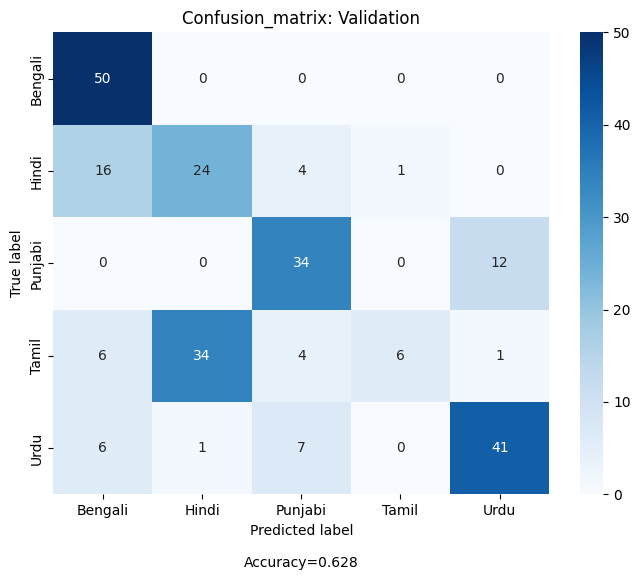

:::::Total vlidation loss 1.302256474737078, Training accuracy 0.6694759020279167, Validation accuracy 0.6275303643724697 after 0 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 1, Batch: 0, Loss: 2.5166797637939453, Accuracy:86.33333333333333%
#####TEST--in-domain:::::Epoch: 1, Batch: 0, Loss: 0.20221664011478424, Accuracy:93.75%


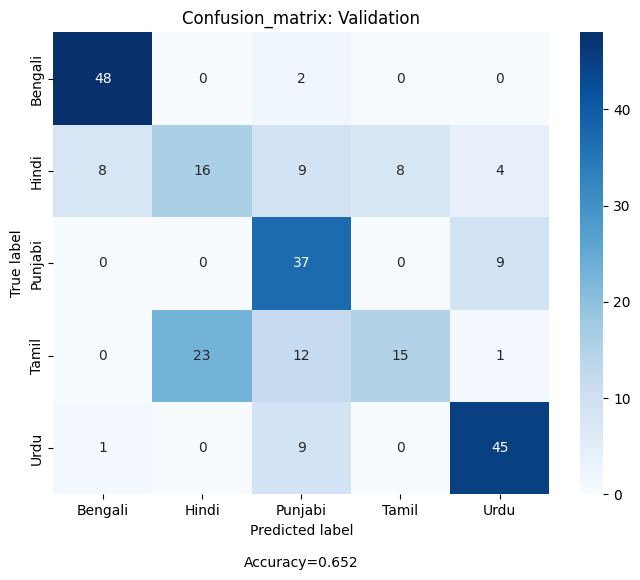

:::::Total vlidation loss 1.659011634066701, Training accuracy 0.8967606004740585, Validation accuracy 0.6518218623481782 after 1 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 2, Batch: 0, Loss: 1.1929374933242798, Accuracy:94.66666666666667%
#####TEST--in-domain:::::Epoch: 2, Batch: 0, Loss: 0.021284069865942, Accuracy:100.0%


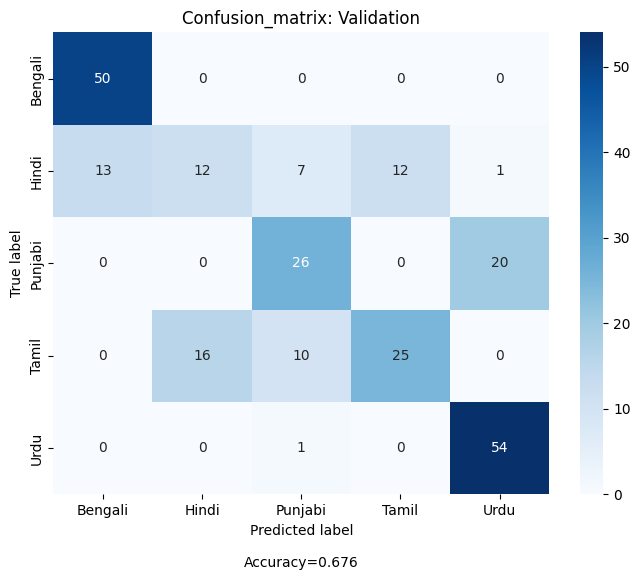

:::::Total vlidation loss 1.9215201861225069, Training accuracy 0.9615485909928891, Validation accuracy 0.6761133603238867 after 2 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 3, Batch: 0, Loss: 0.6588395833969116, Accuracy:97.33333333333334%
#####TEST--in-domain:::::Epoch: 3, Batch: 0, Loss: 0.0013207821175456047, Accuracy:100.0%


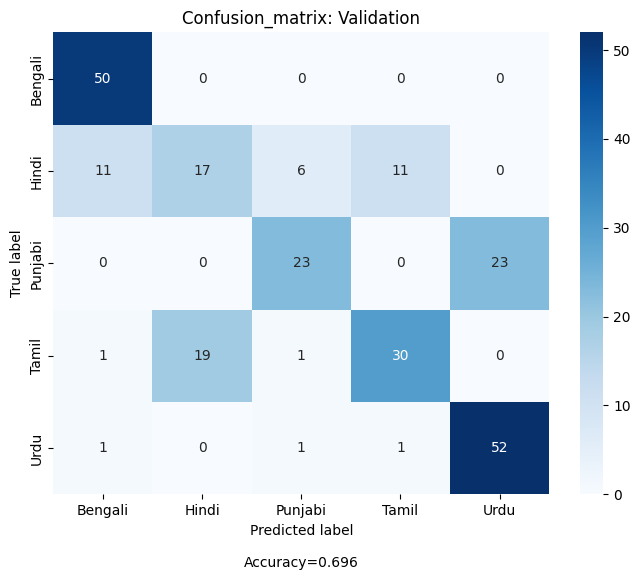

:::::Total vlidation loss 1.558528570807539, Training accuracy 0.9831445878324994, Validation accuracy 0.6963562753036437 after 3 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 4, Batch: 0, Loss: 0.39652299880981445, Accuracy:99.0%
#####TEST--in-domain:::::Epoch: 4, Batch: 0, Loss: 0.005381251219660044, Accuracy:100.0%


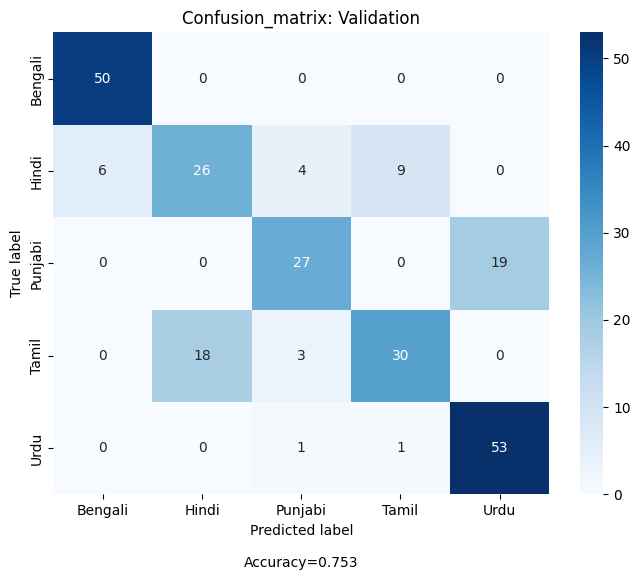

:::::Total vlidation loss 1.630877793126274, Training accuracy 0.9913089281011325, Validation accuracy 0.7530364372469636 after 4 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 5, Batch: 0, Loss: 0.28718870878219604, Accuracy:99.33333333333333%
#####TEST--in-domain:::::Epoch: 5, Batch: 0, Loss: 0.08489113301038742, Accuracy:96.875%


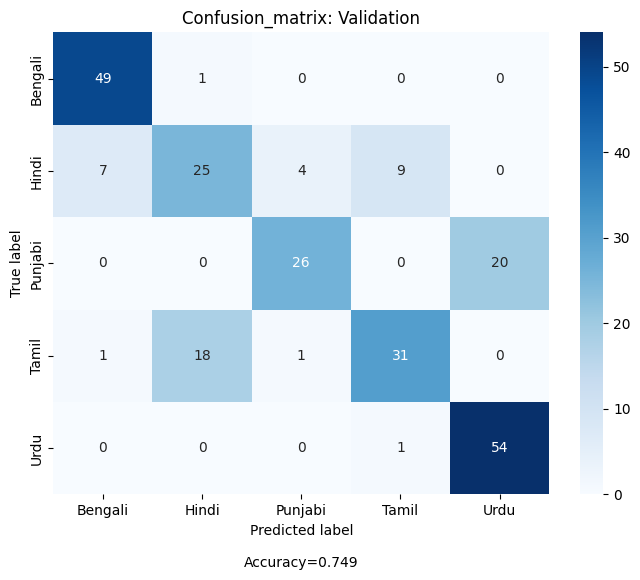

:::::Total vlidation loss 1.5295255410019308, Training accuracy 0.994732683697656, Validation accuracy 0.7489878542510121 after 5 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 6, Batch: 0, Loss: 0.20351313054561615, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 6, Batch: 0, Loss: 0.0005084925796836615, Accuracy:100.0%


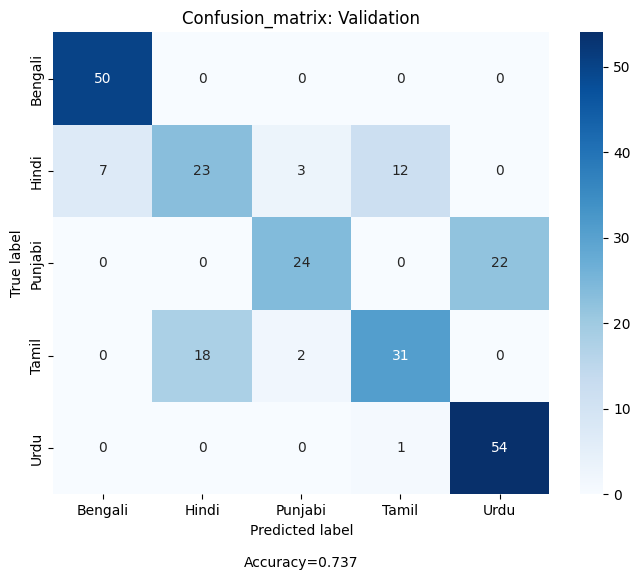

:::::Total vlidation loss 1.7851264830387663, Training accuracy 0.9984198051092968, Validation accuracy 0.7368421052631579 after 6 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 7, Batch: 0, Loss: 0.08564510196447372, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 7, Batch: 0, Loss: 0.06119849532842636, Accuracy:96.875%


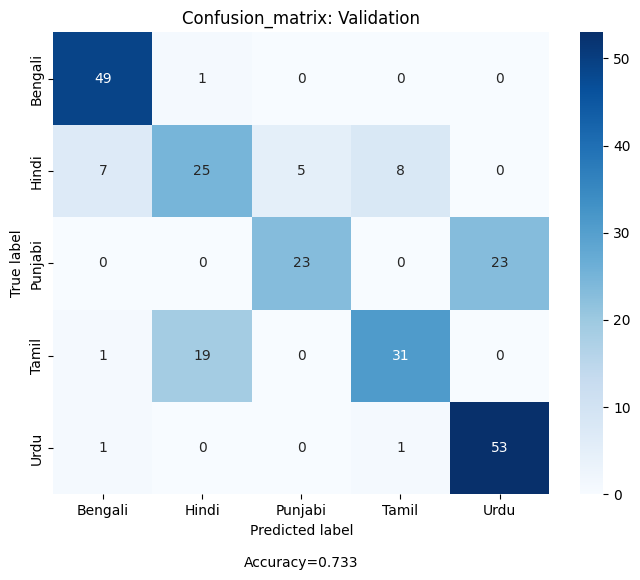

:::::Total vlidation loss 1.6783192728180438, Training accuracy 0.9994732683697656, Validation accuracy 0.7327935222672065 after 7 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 8, Batch: 0, Loss: 0.06958210468292236, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 8, Batch: 0, Loss: 0.1433599889278412, Accuracy:93.75%


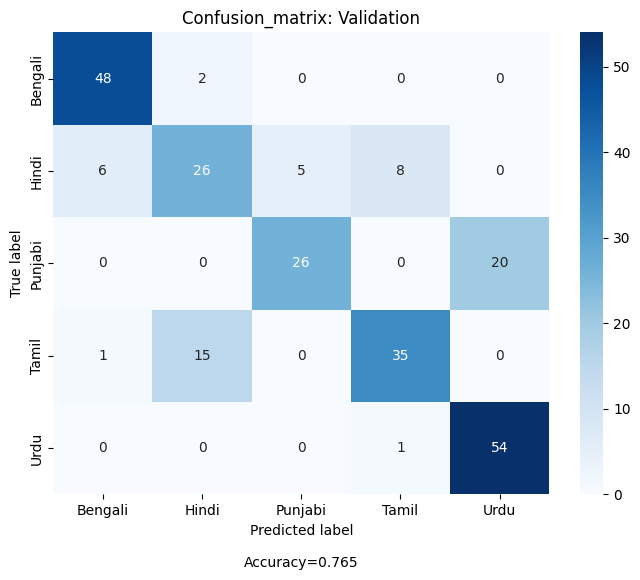

:::::Total vlidation loss 1.5569477272219956, Training accuracy 0.9997366341848828, Validation accuracy 0.7651821862348178 after 8 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 9, Batch: 0, Loss: 0.04121899977326393, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 9, Batch: 0, Loss: 0.10860387235879898, Accuracy:93.75%


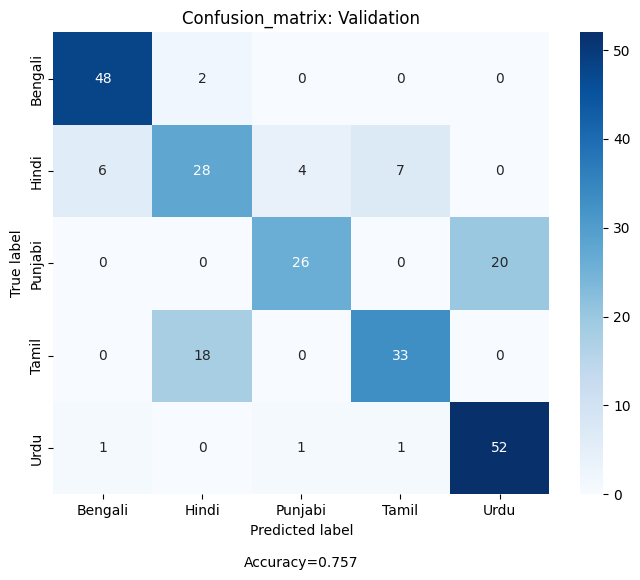

:::::Total vlidation loss 1.5178987961262465, Training accuracy 0.9997366341848828, Validation accuracy 0.757085020242915 after 9 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 10, Batch: 0, Loss: 0.07186730206012726, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 10, Batch: 0, Loss: 0.03361956402659416, Accuracy:96.875%


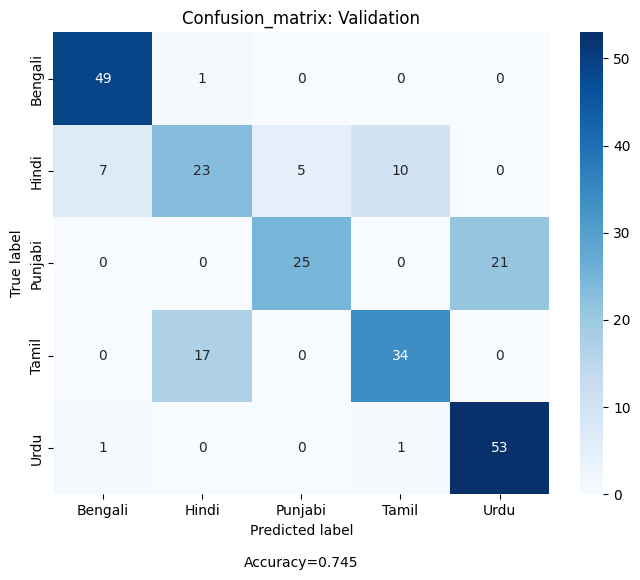

:::::Total vlidation loss 1.5599398277699947, Training accuracy 1.0, Validation accuracy 0.7449392712550608 after 10 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 11, Batch: 0, Loss: 0.034853242337703705, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 11, Batch: 0, Loss: 0.05302060395479202, Accuracy:96.875%


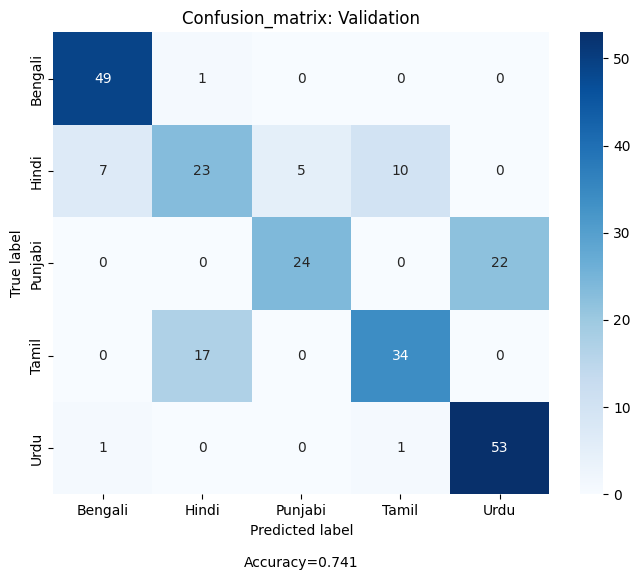

:::::Total vlidation loss 1.600389156024903, Training accuracy 1.0, Validation accuracy 0.7408906882591093 after 11 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 12, Batch: 0, Loss: 0.03576497733592987, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 12, Batch: 0, Loss: 0.125743106007576, Accuracy:96.875%


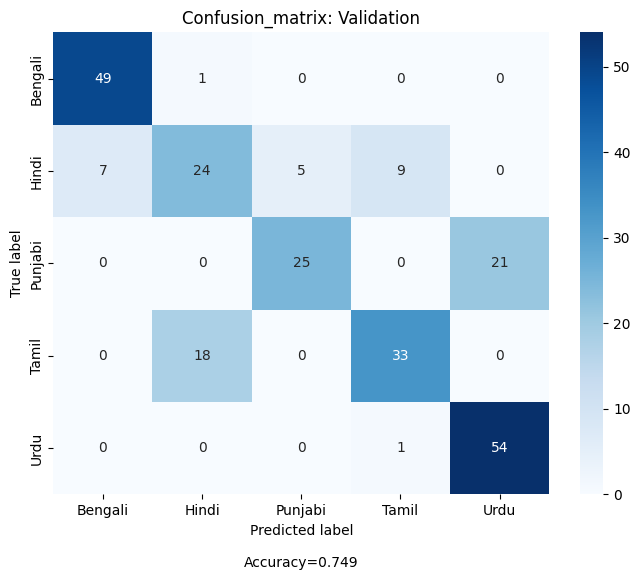

:::::Total vlidation loss 1.678570385556668, Training accuracy 1.0, Validation accuracy 0.7489878542510121 after 12 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 13, Batch: 0, Loss: 0.050912484526634216, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 13, Batch: 0, Loss: 0.1057635173201561, Accuracy:96.875%


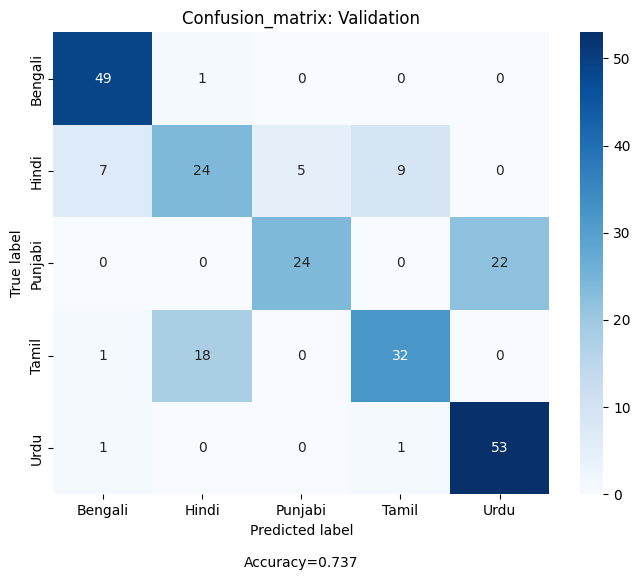

:::::Total vlidation loss 1.6476166821084917, Training accuracy 1.0, Validation accuracy 0.7368421052631579 after 13 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 14, Batch: 0, Loss: 0.013318895362317562, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 14, Batch: 0, Loss: 0.16238532960414886, Accuracy:93.75%


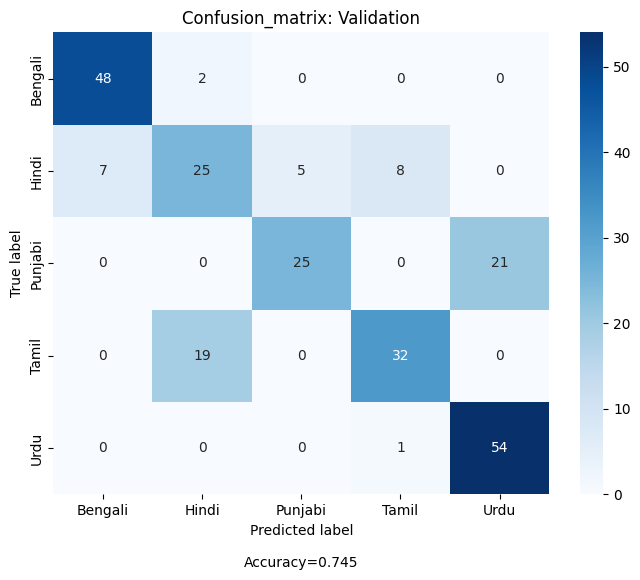

:::::Total vlidation loss 1.6247602244839072, Training accuracy 1.0, Validation accuracy 0.7449392712550608 after 14 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 15, Batch: 0, Loss: 0.031102526932954788, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 15, Batch: 0, Loss: 0.1624012291431427, Accuracy:93.75%


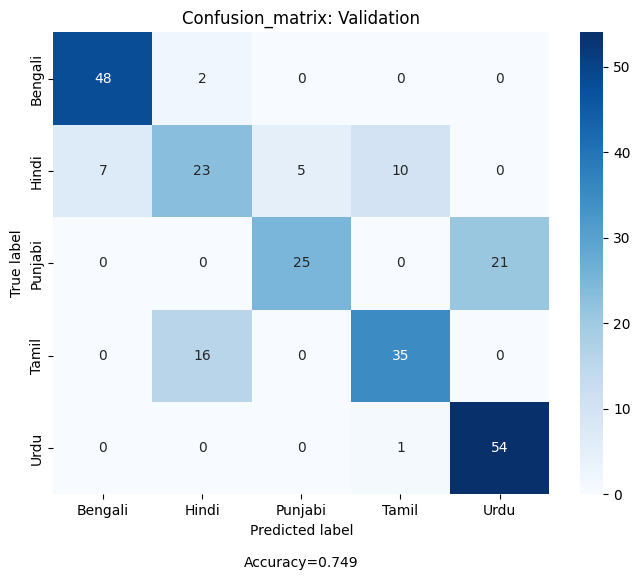

:::::Total vlidation loss 1.5790115732233971, Training accuracy 1.0, Validation accuracy 0.7489878542510121 after 15 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 16, Batch: 0, Loss: 0.021799320355057716, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 16, Batch: 0, Loss: 0.10918597877025604, Accuracy:93.75%


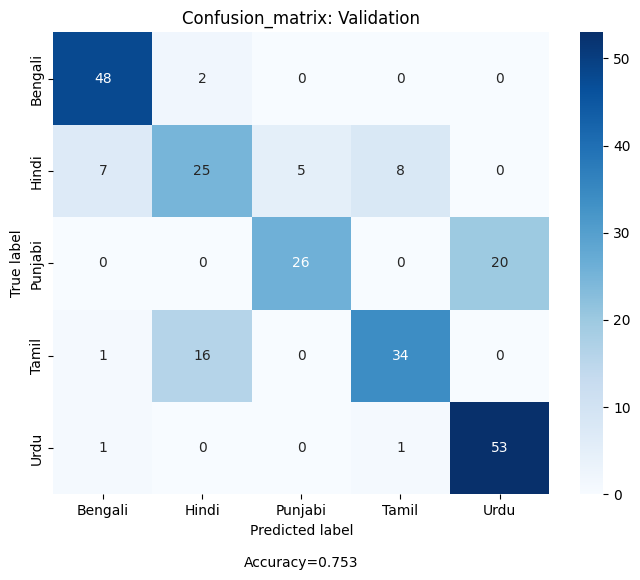

:::::Total vlidation loss 1.5984841072931886, Training accuracy 1.0, Validation accuracy 0.7530364372469636 after 16 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 17, Batch: 0, Loss: 0.024626288563013077, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 17, Batch: 0, Loss: 0.15309543907642365, Accuracy:93.75%


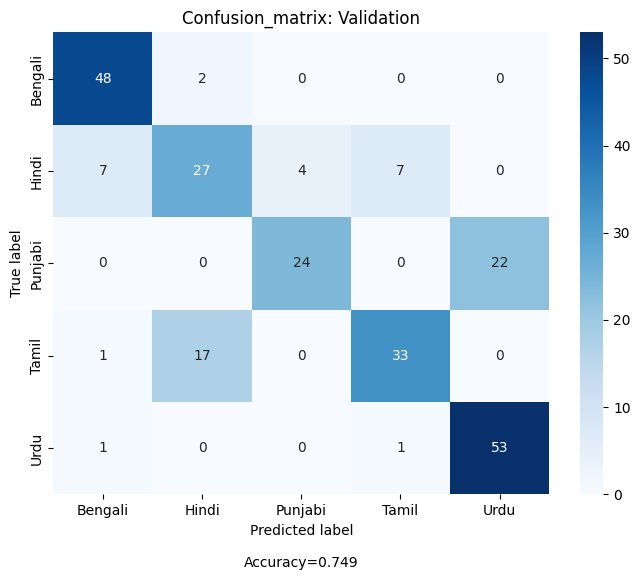

:::::Total vlidation loss 1.6571195302531123, Training accuracy 1.0, Validation accuracy 0.7489878542510121 after 17 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 18, Batch: 0, Loss: 0.024735495448112488, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 18, Batch: 0, Loss: 0.13973276317119598, Accuracy:93.75%


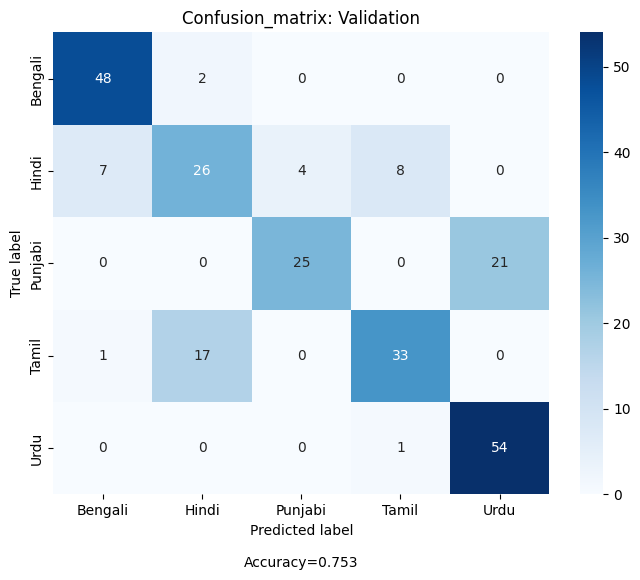

:::::Total vlidation loss 1.6628178234677762, Training accuracy 1.0, Validation accuracy 0.7530364372469636 after 18 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 19, Batch: 0, Loss: 0.02173256129026413, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 19, Batch: 0, Loss: 0.11895836144685745, Accuracy:93.75%


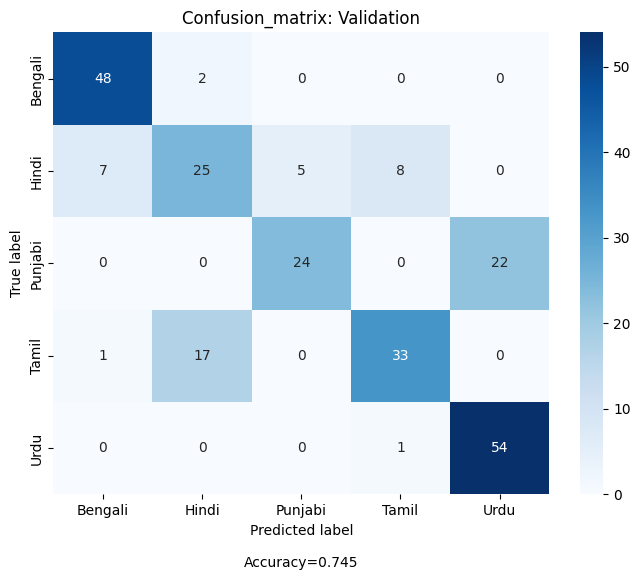

:::::Total vlidation loss 1.6863474301062524, Training accuracy 1.0, Validation accuracy 0.7449392712550608 after 19 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 20, Batch: 0, Loss: 0.05028345063328743, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 20, Batch: 0, Loss: 0.11727398633956909, Accuracy:93.75%


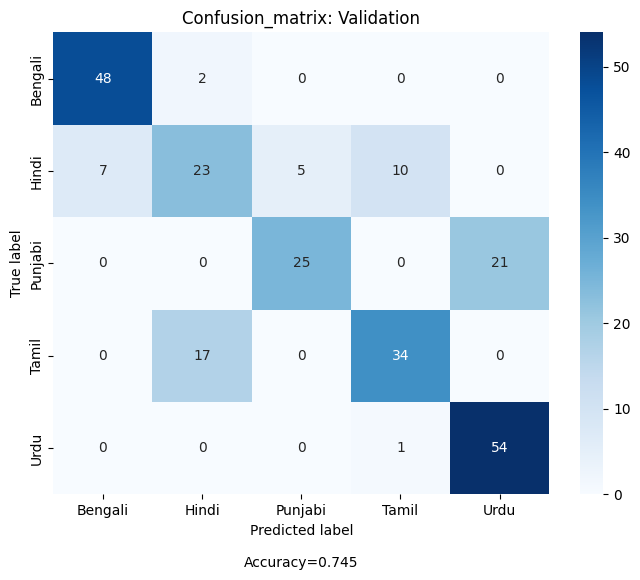

:::::Total vlidation loss 1.6504160182084888, Training accuracy 1.0, Validation accuracy 0.7449392712550608 after 20 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 21, Batch: 0, Loss: 0.02406352385878563, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 21, Batch: 0, Loss: 0.12203893065452576, Accuracy:93.75%


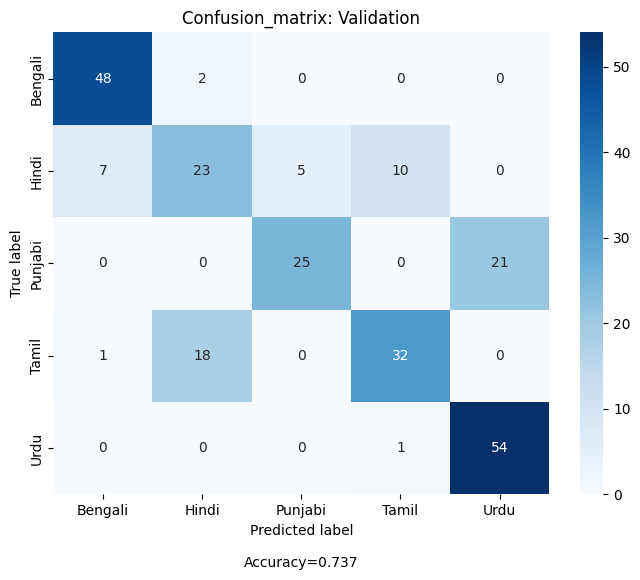

:::::Total vlidation loss 1.6741492052096874, Training accuracy 1.0, Validation accuracy 0.7368421052631579 after 21 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 22, Batch: 0, Loss: 0.02380875125527382, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 22, Batch: 0, Loss: 0.15133291482925415, Accuracy:93.75%


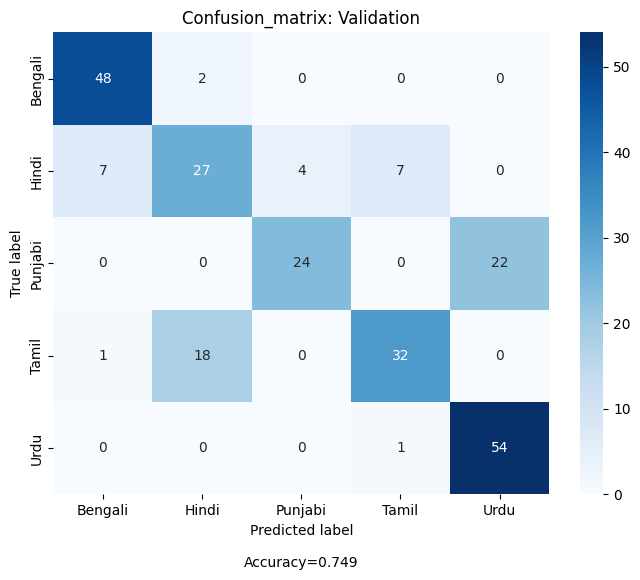

:::::Total vlidation loss 1.6967175940517336, Training accuracy 0.9997366341848828, Validation accuracy 0.7489878542510121 after 22 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 23, Batch: 0, Loss: 0.04016727954149246, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 23, Batch: 0, Loss: 0.173052579164505, Accuracy:93.75%


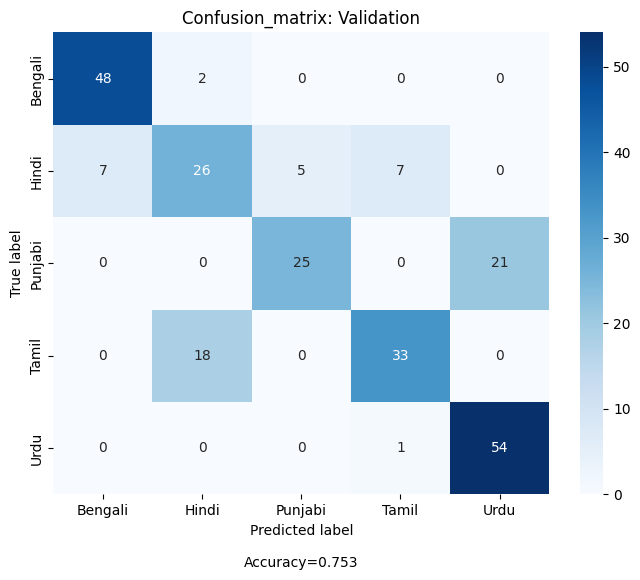

:::::Total vlidation loss 1.644101886311546, Training accuracy 1.0, Validation accuracy 0.7530364372469636 after 23 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 24, Batch: 0, Loss: 0.03486216813325882, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 24, Batch: 0, Loss: 0.10137611627578735, Accuracy:93.75%


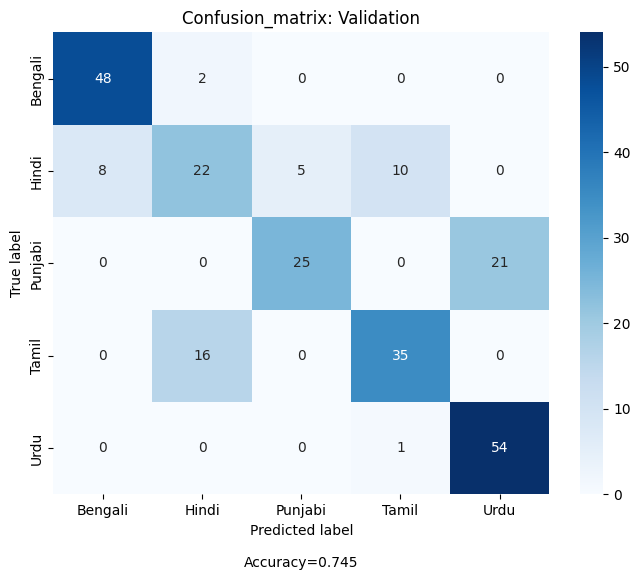

:::::Total vlidation loss 1.6687857231590897, Training accuracy 1.0, Validation accuracy 0.7449392712550608 after 24 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 25, Batch: 0, Loss: 0.022147877141833305, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 25, Batch: 0, Loss: 0.08844184130430222, Accuracy:96.875%


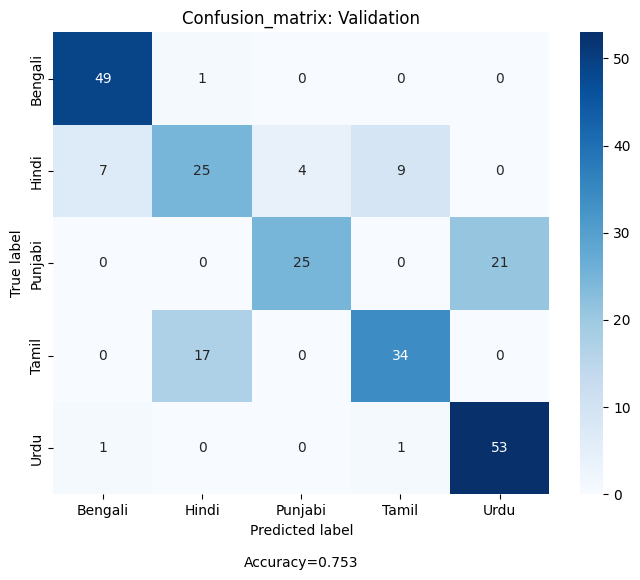

:::::Total vlidation loss 1.640758253633976, Training accuracy 1.0, Validation accuracy 0.7530364372469636 after 25 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 26, Batch: 0, Loss: 0.02044043503701687, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 26, Batch: 0, Loss: 0.07523860037326813, Accuracy:96.875%


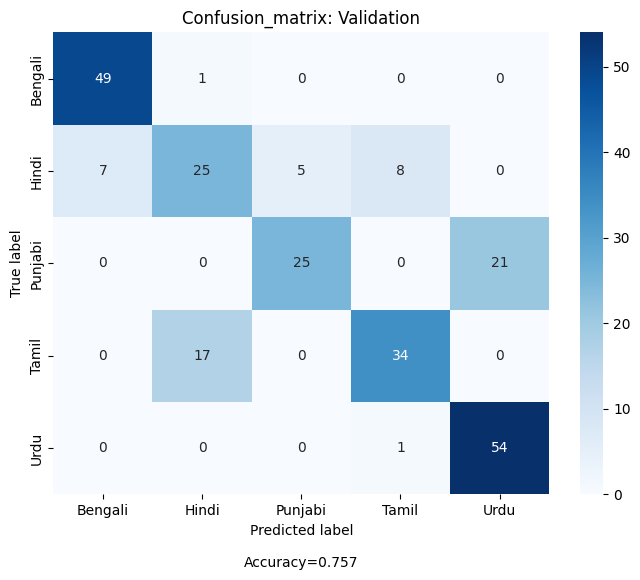

:::::Total vlidation loss 1.650396855082363, Training accuracy 1.0, Validation accuracy 0.757085020242915 after 26 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 27, Batch: 0, Loss: 0.033249542117118835, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 27, Batch: 0, Loss: 0.06177247315645218, Accuracy:96.875%


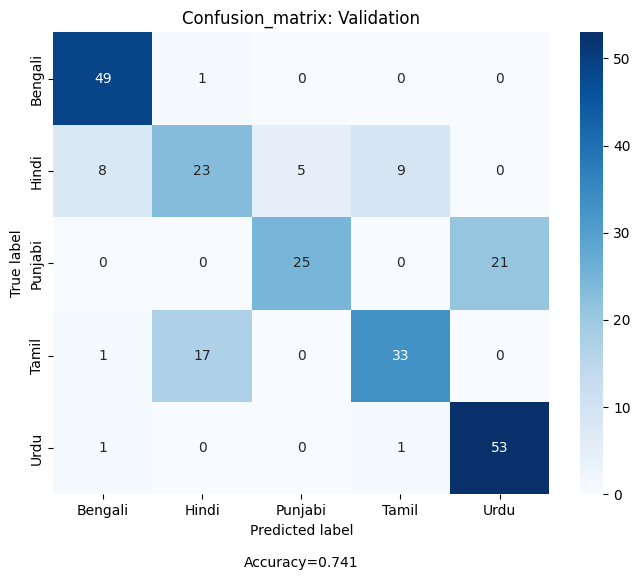

:::::Total vlidation loss 1.6535087935626507, Training accuracy 1.0, Validation accuracy 0.7408906882591093 after 27 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 28, Batch: 0, Loss: 0.04315708950161934, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 28, Batch: 0, Loss: 0.13037626445293427, Accuracy:93.75%


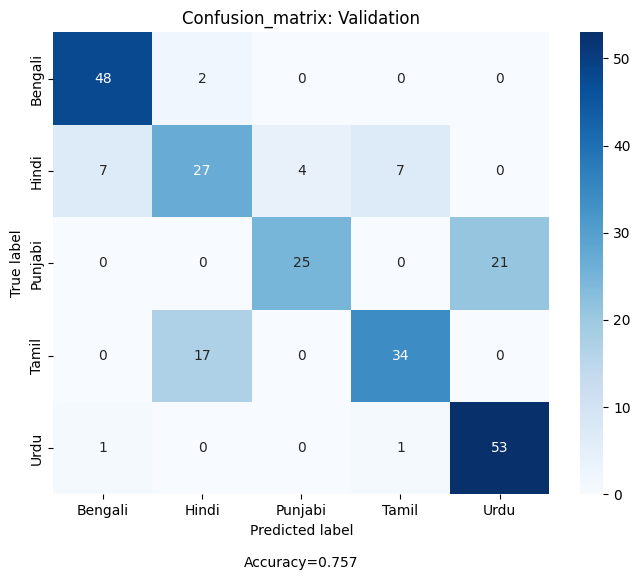

:::::Total vlidation loss 1.6382693550549448, Training accuracy 1.0, Validation accuracy 0.757085020242915 after 28 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 29, Batch: 0, Loss: 0.015940677374601364, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 29, Batch: 0, Loss: 0.06348596513271332, Accuracy:96.875%


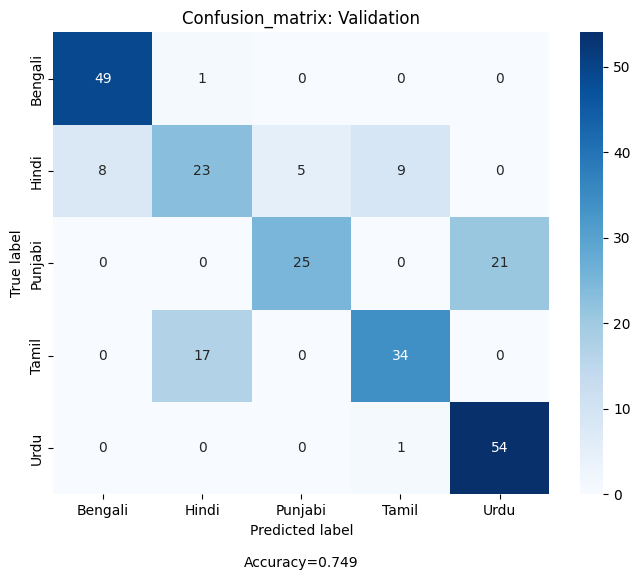

:::::Total vlidation loss 1.6502150257583708, Training accuracy 1.0, Validation accuracy 0.7489878542510121 after 29 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 30, Batch: 0, Loss: 0.026171864941716194, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 30, Batch: 0, Loss: 0.08473841845989227, Accuracy:96.875%


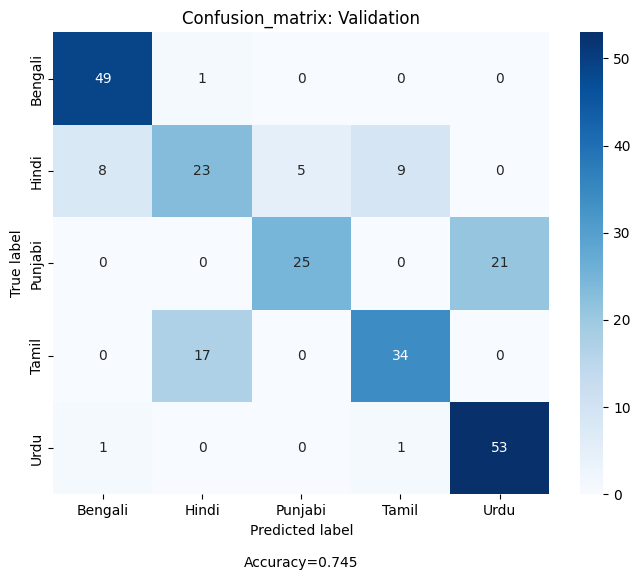

:::::Total vlidation loss 1.678855985403061, Training accuracy 1.0, Validation accuracy 0.7449392712550608 after 30 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 31, Batch: 0, Loss: 0.044217515736818314, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 31, Batch: 0, Loss: 0.09629643708467484, Accuracy:93.75%


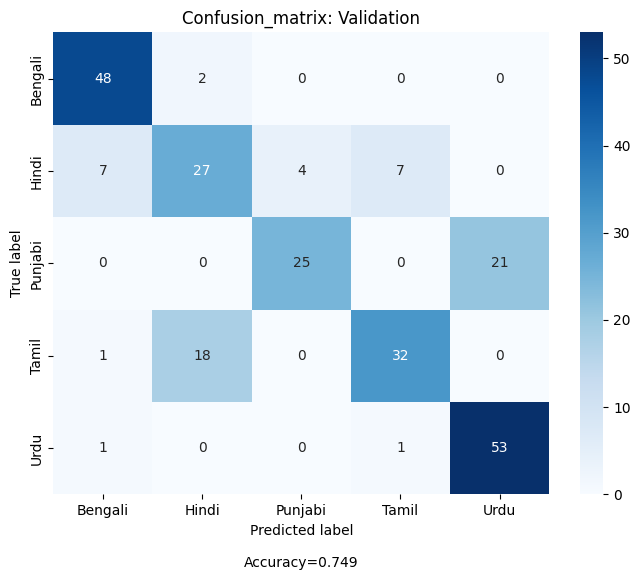

:::::Total vlidation loss 1.650899076834321, Training accuracy 1.0, Validation accuracy 0.7489878542510121 after 31 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 32, Batch: 0, Loss: 0.013336415402591228, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 32, Batch: 0, Loss: 0.10010956972837448, Accuracy:93.75%


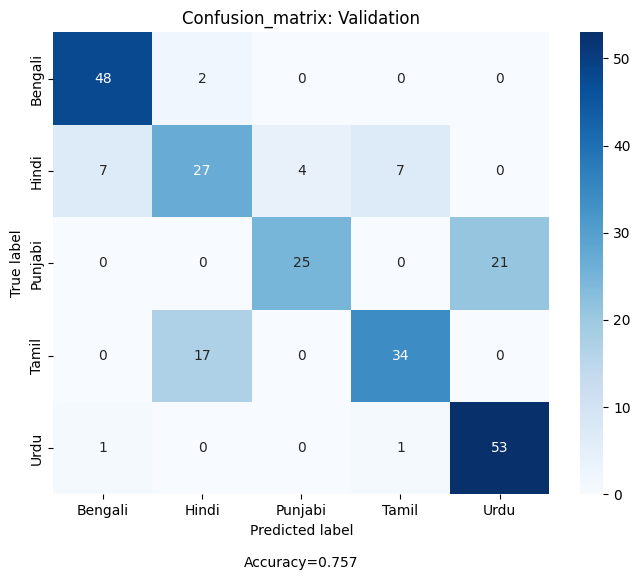

:::::Total vlidation loss 1.6275396174751222, Training accuracy 1.0, Validation accuracy 0.757085020242915 after 32 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 33, Batch: 0, Loss: 0.01951213926076889, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 33, Batch: 0, Loss: 0.06054379418492317, Accuracy:96.875%


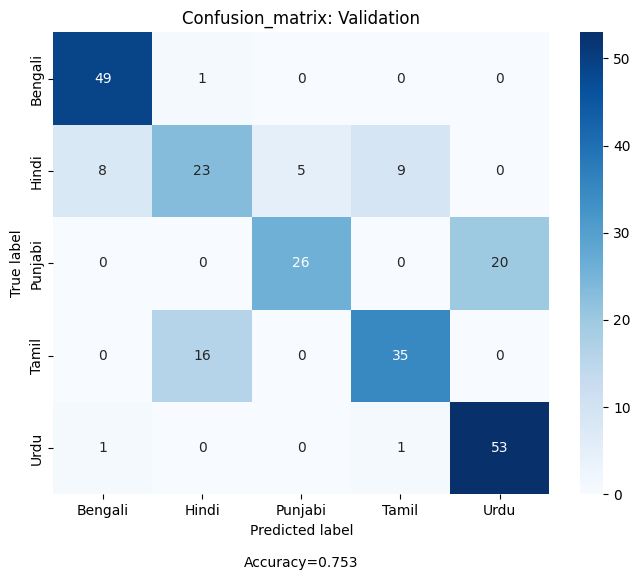

:::::Total vlidation loss 1.631438713055104, Training accuracy 0.9997366341848828, Validation accuracy 0.7530364372469636 after 33 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 34, Batch: 0, Loss: 0.023144328966736794, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 34, Batch: 0, Loss: 0.08029433339834213, Accuracy:96.875%


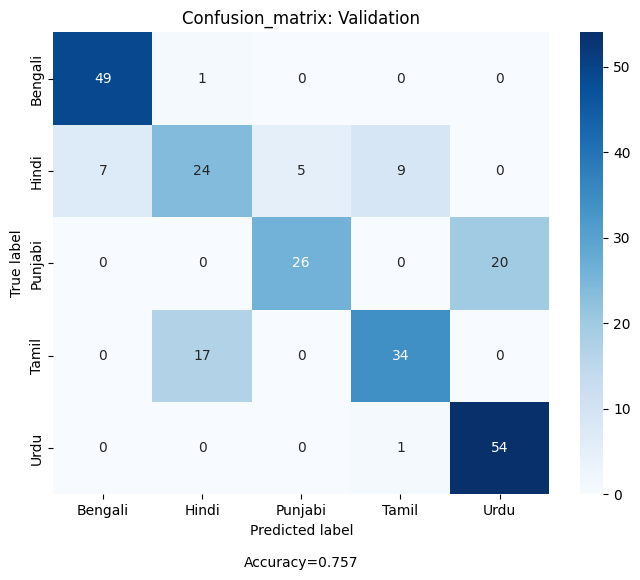

:::::Total vlidation loss 1.630253097973764, Training accuracy 0.9997366341848828, Validation accuracy 0.757085020242915 after 34 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 35, Batch: 0, Loss: 0.05646548047661781, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 35, Batch: 0, Loss: 0.12944422662258148, Accuracy:93.75%


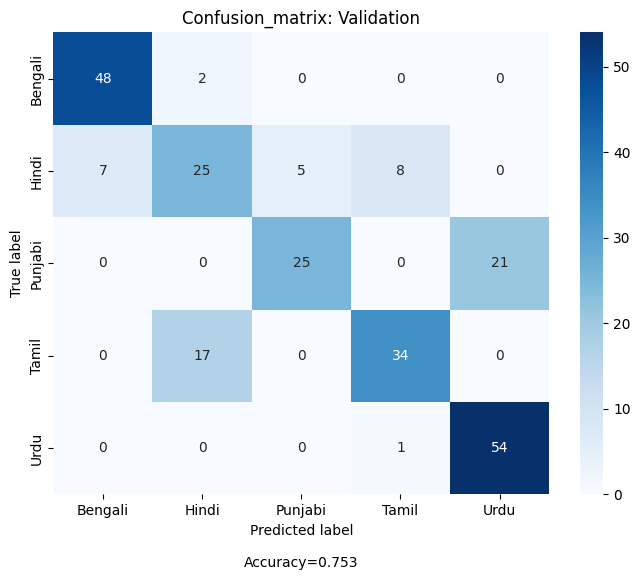

:::::Total vlidation loss 1.6278659254312515, Training accuracy 1.0, Validation accuracy 0.7530364372469636 after 35 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 36, Batch: 0, Loss: 0.0212409608066082, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 36, Batch: 0, Loss: 0.11222891509532928, Accuracy:93.75%


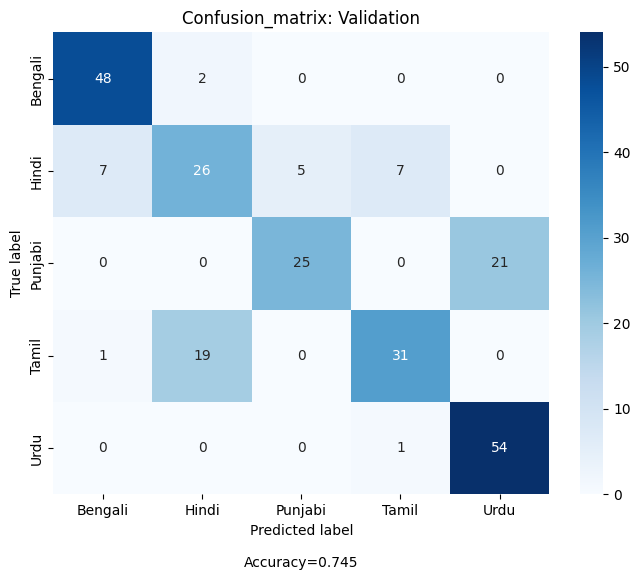

:::::Total vlidation loss 1.6604933277703822, Training accuracy 1.0, Validation accuracy 0.7449392712550608 after 36 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 37, Batch: 0, Loss: 0.02052205055952072, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 37, Batch: 0, Loss: 0.07997447997331619, Accuracy:96.875%


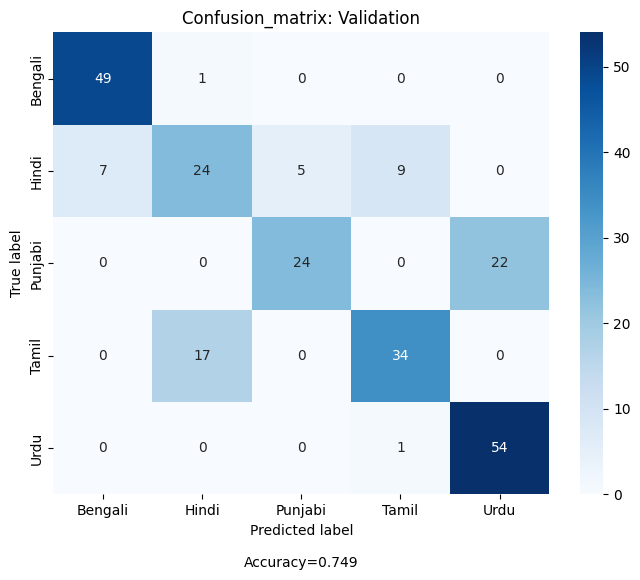

:::::Total vlidation loss 1.6765421014279127, Training accuracy 1.0, Validation accuracy 0.7489878542510121 after 37 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 38, Batch: 0, Loss: 0.027087831869721413, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 38, Batch: 0, Loss: 0.08020512759685516, Accuracy:96.875%


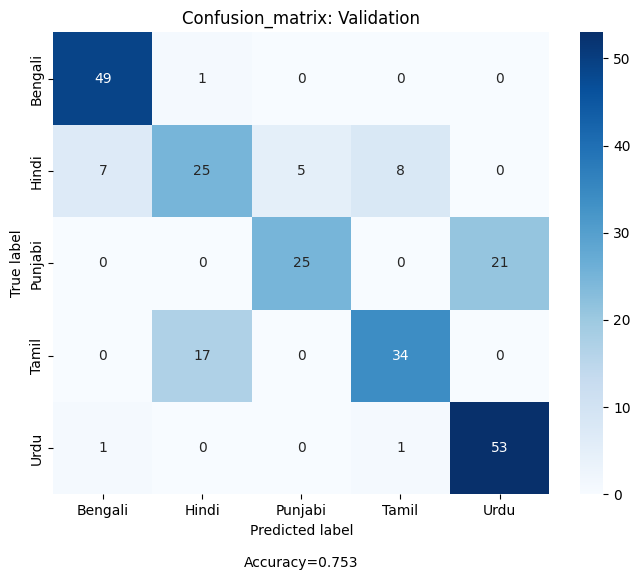

:::::Total vlidation loss 1.661185972392559, Training accuracy 1.0, Validation accuracy 0.7530364372469636 after 38 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 39, Batch: 0, Loss: 0.028432553634047508, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 39, Batch: 0, Loss: 0.06955888867378235, Accuracy:96.875%


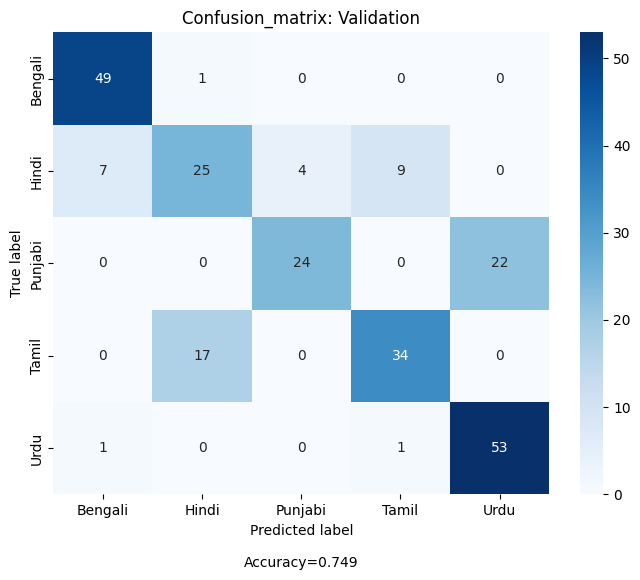

:::::Total vlidation loss 1.6866748402826488, Training accuracy 1.0, Validation accuracy 0.7489878542510121 after 39 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 40, Batch: 0, Loss: 0.023367835208773613, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 40, Batch: 0, Loss: 0.1070193201303482, Accuracy:93.75%


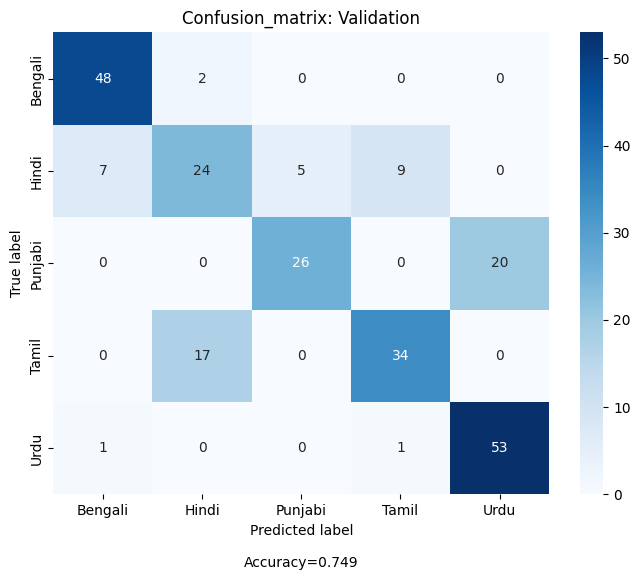

:::::Total vlidation loss 1.618429095018655, Training accuracy 1.0, Validation accuracy 0.7489878542510121 after 40 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 41, Batch: 0, Loss: 0.023431818932294846, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 41, Batch: 0, Loss: 0.09598466753959656, Accuracy:96.875%


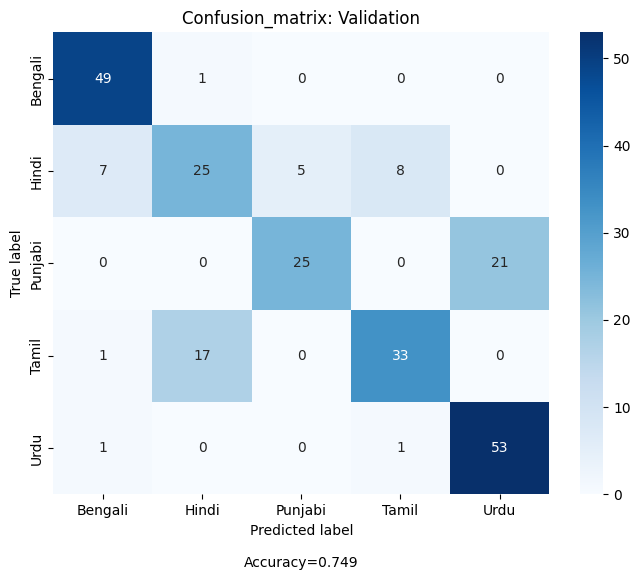

:::::Total vlidation loss 1.6490685855969787, Training accuracy 1.0, Validation accuracy 0.7489878542510121 after 41 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 42, Batch: 0, Loss: 0.02713090181350708, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 42, Batch: 0, Loss: 0.084914430975914, Accuracy:96.875%


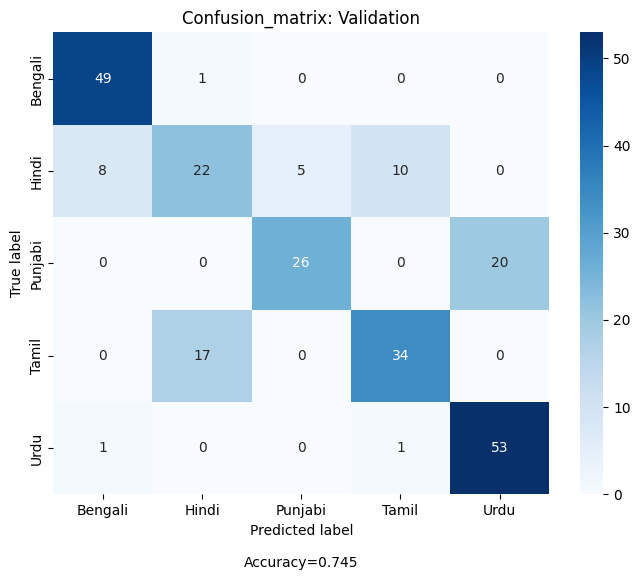

:::::Total vlidation loss 1.645265913568437, Training accuracy 1.0, Validation accuracy 0.7449392712550608 after 42 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 43, Batch: 0, Loss: 0.024611765518784523, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 43, Batch: 0, Loss: 0.08444513380527496, Accuracy:96.875%


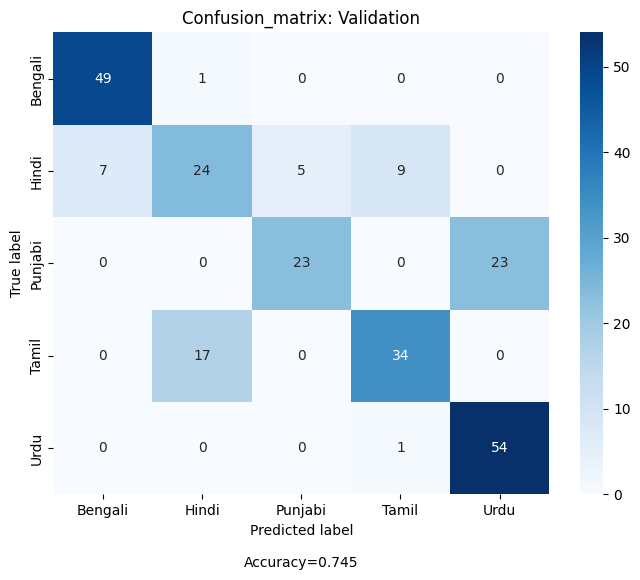

:::::Total vlidation loss 1.700157061452046, Training accuracy 1.0, Validation accuracy 0.7449392712550608 after 43 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 44, Batch: 0, Loss: 0.02690841071307659, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 44, Batch: 0, Loss: 0.0850544422864914, Accuracy:96.875%


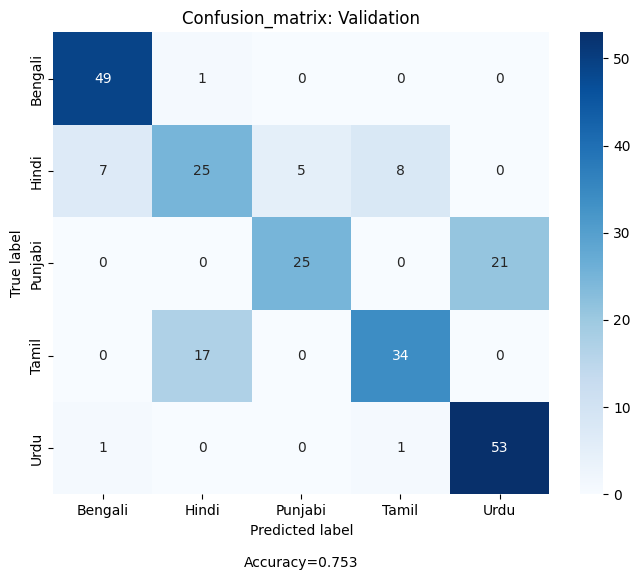

:::::Total vlidation loss 1.650377744808793, Training accuracy 1.0, Validation accuracy 0.7530364372469636 after 44 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 45, Batch: 0, Loss: 0.023253362625837326, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 45, Batch: 0, Loss: 0.10734975337982178, Accuracy:93.75%


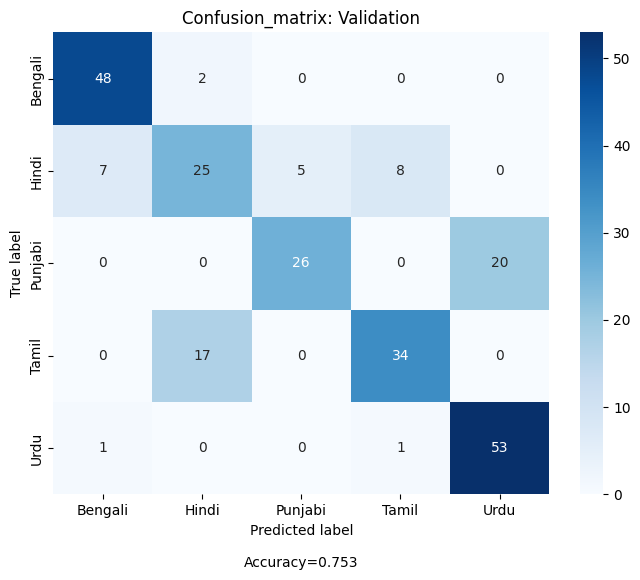

:::::Total vlidation loss 1.6338976547122002, Training accuracy 1.0, Validation accuracy 0.7530364372469636 after 45 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 46, Batch: 0, Loss: 0.03131604567170143, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 46, Batch: 0, Loss: 0.1045231819152832, Accuracy:93.75%


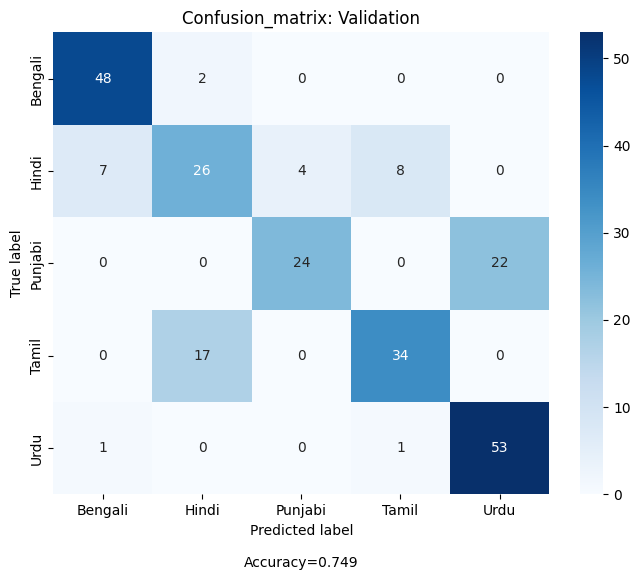

:::::Total vlidation loss 1.6733323503285646, Training accuracy 1.0, Validation accuracy 0.7489878542510121 after 46 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 47, Batch: 0, Loss: 0.01213851384818554, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 47, Batch: 0, Loss: 0.06638212502002716, Accuracy:96.875%


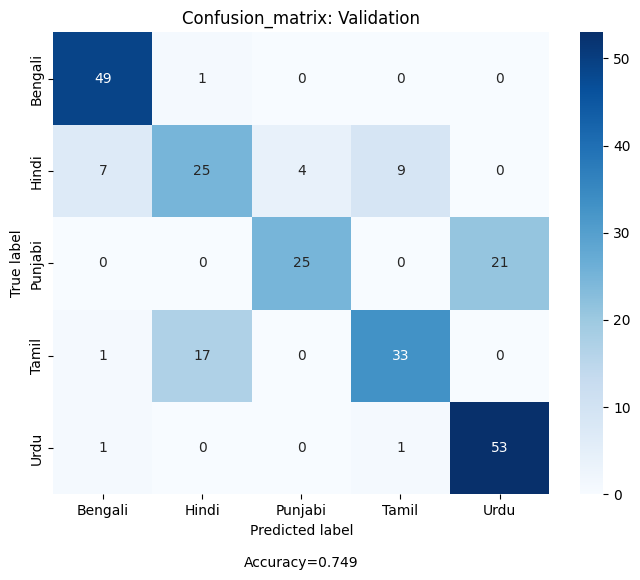

:::::Total vlidation loss 1.6590285901911557, Training accuracy 1.0, Validation accuracy 0.7489878542510121 after 47 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 48, Batch: 0, Loss: 0.029728829860687256, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 48, Batch: 0, Loss: 0.07191980630159378, Accuracy:96.875%


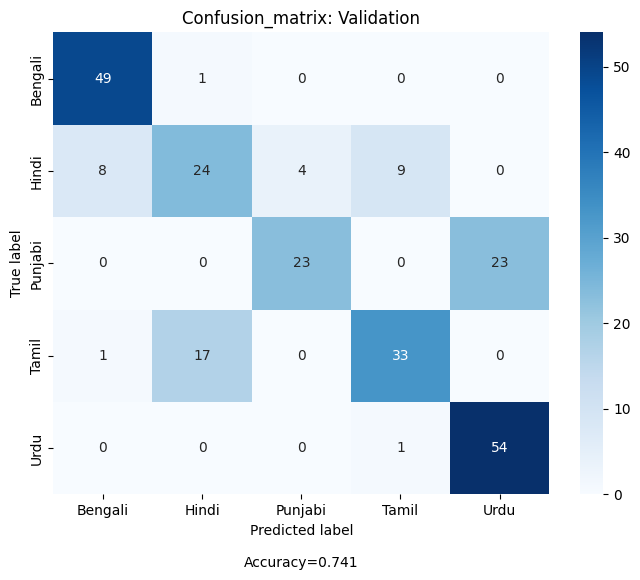

:::::Total vlidation loss 1.701307461131364, Training accuracy 1.0, Validation accuracy 0.7408906882591093 after 48 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 49, Batch: 0, Loss: 0.014833749271929264, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 49, Batch: 0, Loss: 0.08592162281274796, Accuracy:96.875%


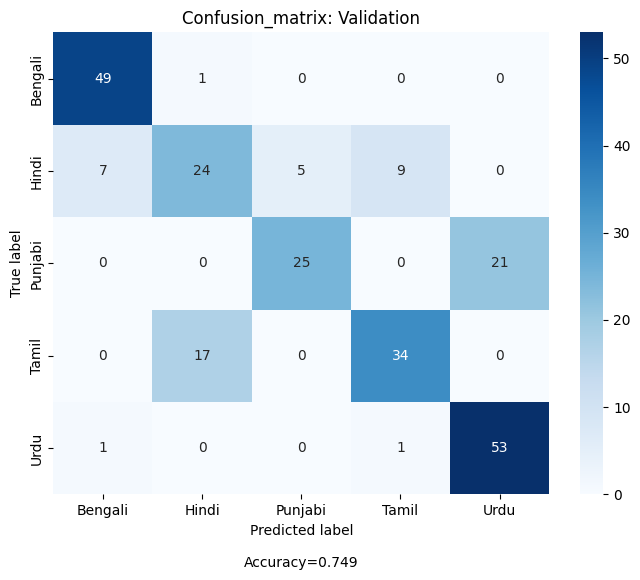

:::::Total vlidation loss 1.6358716036193073, Training accuracy 1.0, Validation accuracy 0.7489878542510121 after 49 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############


In [13]:
#For LR scheduler
import warnings
warnings.filterwarnings('ignore')
dest_path="/home/bhagya/Data_Bhagya_internship_wav2vec_xlsr_IIITH_23L/"
os.makedirs(dest_path,exist_ok=True)
#Languages=["Assamese","Bengali","Bodo","Dogri","English","Gujarati","Hindi","Kannada","Kashmiri","Konkani","Maithili","Manipuri","Malayalam","Marathi","Nepali","Odia","Punjabi","Sanskrit","Santali","Sindhi","Tamil","Telugu","Urdu"]
Languages=["Bengali","Hindi","Punjabi","Tamil","Urdu"]
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import cf_matrix
def train(dataloader_train,epoch):
    train_loss_list=[]
    train_acc_list=[]
    full_preds=[]
    full_gts=[]

    model.train()
    for i_batch, data in enumerate(dataloader_train, 0):
        features, labels = data
        #features=torch.transpose(features,0,2,1)
        #print(features.shape)
        #print(labels.shape)
        #features=minmax(features)
        features, labels = features.to(device).float(),labels.to(device).long()
        features.requires_grad = True
        optimizer.zero_grad()
        pred_logits = model(features)
        loss=model.get_loss(pred_logits,labels)
        posterior=model.get_posterior()
        #print(posterior.shape)
        #loss = loss_fun(pred_logits,labels)

        #print(pred_logits.shape)
        #LOSS=[]
        #for ii in range(features.shape[1]):
        #    loss = loss_fun(features[:,ii,:],labels)
        #    LOSS.append(loss)
        #loss=torch.mean(torch.tensor(LOSS))
        #loss.requires_grad_(True)
        loss.backward()
        optimizer.step()
        predictions = np.argmax(posterior.detach().cpu().numpy(),axis=1)
        if i_batch%50==0:
            #print(final_pred)
            acc = accuracy_score(predictions,labels.cpu())
            print(f"Epoch: {epoch}, Batch: {i_batch}, Loss: {loss}, Accuracy:{acc*100}%")
        train_loss_list.append(loss.item())
        for pred in predictions:
            full_preds.append(pred)
        for lab in labels.detach().cpu().numpy():
            full_gts.append(lab)
    mean_acc = accuracy_score(full_gts,full_preds)
    mean_loss = np.mean(np.asarray(train_loss_list))
    return mean_acc
    print('Total training loss {} and training Accuracy {} after {} epochs'.format(mean_loss,mean_acc,epoch))
def validation(dataloader_val,epoch,train_accuracy):
    model.eval()
    with torch.no_grad():
        val_loss_list=[]
        full_preds=[]
        full_gts=[]
        for i_batch, data in enumerate(dataloader_val, 0):
            features, labels = data
            #features=torch.transpose(features,0,2,1)
            features, labels = features.to(device).float(),labels.to(device).long()
            pred_logits = model(features)
            #print(features.shape)
            #print(labels.shape)
            loss=model.get_loss(pred_logits,labels)
            posterior=model.get_posterior()
            #loss = loss_fun(pred_logits,labels)
            val_loss_list.append(loss.item())
            predictions = np.argmax(posterior.detach().cpu().numpy(),axis=1)
            if i_batch%50==0:
                #print(final_pred)
                acc = accuracy_score(predictions,labels.cpu())
                print(f"#####TEST--in-domain:::::Epoch: {epoch}, Batch: {i_batch}, Loss: {loss}, Accuracy:{acc*100}%")
            for pred in predictions:
                full_preds.append(pred)
            for lab in labels.detach().cpu().numpy():
                full_gts.append(lab)

        mean_acc2 = accuracy_score(full_gts,full_preds)
        mean_loss2 = np.mean(np.asarray(val_loss_list))
        cm=confusion_matrix(full_gts,full_preds)
        cf_matrix.make_confusion_matrix(cm, percent=False, figsize=(8,6), categories=Languages, cbar=True, title="Confusion_matrix: Validation")
        plt.show()
        print(':::::Total vlidation loss {}, Training accuracy {}, Validation accuracy {} after {} epochs'.format(mean_loss2,train_accuracy, mean_acc2,epoch))
        print("#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############")
        model_save_path = os.path.join(dest_path,'kgp_withoutAug_Bhagya_ecapa_cms_'+str("{:.3f}".format(train_accuracy*100))+"_"+str("{:.3f}".format(mean_acc2*100))+"_"+str("{:.4f}".format(mean_loss2)))
        state_dict = {'model': model.state_dict(),'optimizer': optimizer.state_dict(),'epoch': epoch}
        torch.save(state_dict, model_save_path)
        return loss

if __name__ == '__main__':
    for epoch in range(50):
        mean_acc=train(trainloader,epoch)
        val_loss=validation(testloader1,epoch,mean_acc)
        scheduler.step(val_loss)
        #testing(testloader2,epoch,mean_acc)
        #testing(testloader3,epoch,mean_acc)